<a href="https://colab.research.google.com/github/mehmetalivarol/time-series-analysis-with-lstm/blob/master/lstm_time_series_DO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
mpl.rcParams['figure.figsize'] = (12, 7)
mpl.rcParams['axes.grid'] = False

df=pd.read_excel('/content/drive/My Drive/Colab Data/DO.linkterasend.xlsx', delimiter=';')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (761, 7)


,Date,Units,IsGunuKatsayi,DayOfWeek,WorkDayOfWeek,WorkDayOfMonth2,GeriOdemeDurum
0,2017-07-01,1043,0.2500,6,0,0,REIM
1,2017-07-02,107,0.0500,7,0,0,REIM
2,2017-07-03,3584,1.0000,1,1,1,REIM
3,2017-07-04,2994,1.0000,2,2,2,REIM
4,2017-07-05,2587,1.0000,3,3,3,REIM


In [0]:
df['Units'] = pd.to_numeric(df['Units'], errors='coerce')
df = df.dropna(subset=['Units'])
df['Year'] = df['Date'].apply(lambda x: x.year)
df['Quarter'] = df['Date'].apply(lambda x: x.quarter)
df['Month'] = df['Date'].apply(lambda x: x.month)
df['Day'] = df['Date'].apply(lambda x: x.day)
df=df.loc[:,['Date','Units','IsGunuKatsayi','Year','Quarter','Month','Day']]
df.sort_values('Date', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["Date"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.Date.min())
print('The time series ends on: ', df.Date.max())

Number of rows and columns after removing missing values: (761, 8)
The time series starts from:  2017-07-01 00:00:00
The time series ends on:  2019-07-31 00:00:00


In [0]:
df.head()

,Date,Units,IsGunuKatsayi,Year,Quarter,Month,Day,weekday
0,2017-07-01,1043,0.2500,2017,3,7,1,0
1,2017-07-02,107,0.0500,2017,3,7,2,0
2,2017-07-03,3584,1.0000,2017,3,7,3,1
3,2017-07-04,2994,1.0000,2017,3,7,4,1
4,2017-07-05,2587,1.0000,2017,3,7,5,1


In [0]:
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(df.Units, m=2, r=0.2*np.std(df.Units))) 
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))  

0.9816962984946614
inf
2.236833715431265


In [0]:
stat, p = stats.normaltest(df.Units)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=1074.178, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 115.78151747535092
Skewness of normal distribution: 7.387471109906552


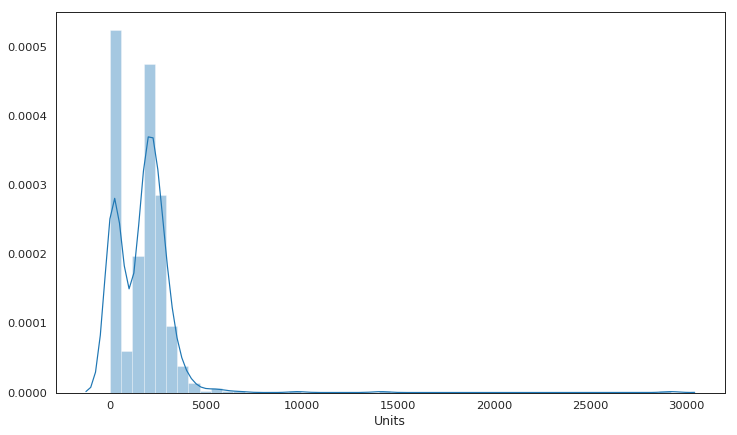

In [0]:
sns.distplot(df.Units);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Units)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Units)))

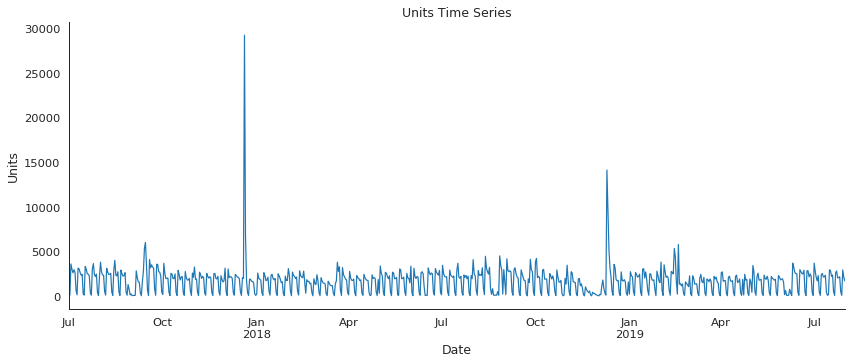

In [0]:
df1=df.loc[:,['Date','Units']]
df1.set_index('Date',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Units')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Units Time Series')
sns.despine(top=True)
plt.show();

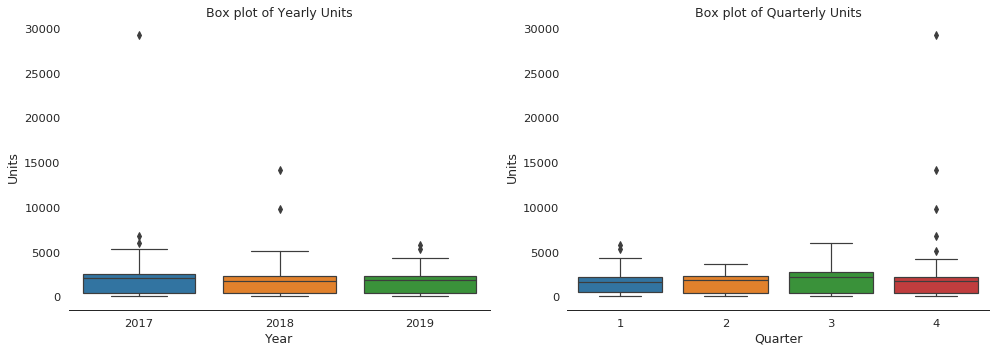

In [0]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="Year", y="Units", data=df)
plt.xlabel('Year')
plt.title('Box plot of Yearly Units')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="Quarter", y="Units", data=df)
plt.xlabel('Quarter')
plt.title('Box plot of Quarterly Units')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
Units,761.0000,1689.5059,1608.8917,10.0000,405.0000,1876.0000,2411.0000,29193.0000


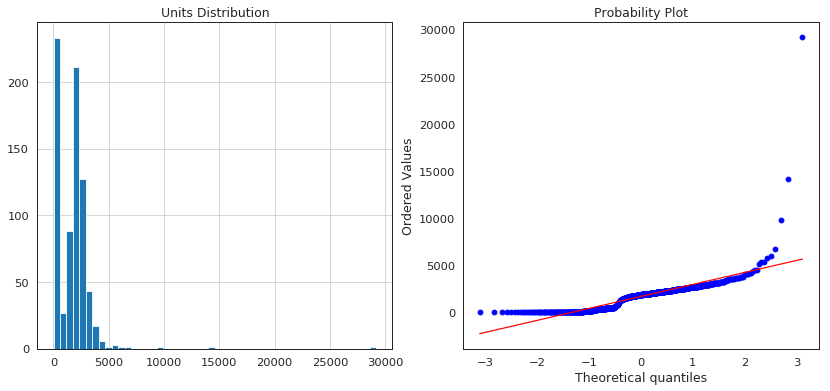

In [0]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Units'].hist(bins=50)
plt.title('Units Distribution')
plt.subplot(1,2,2)
stats.probplot(df['Units'], plot=plt);
df1.describe().T

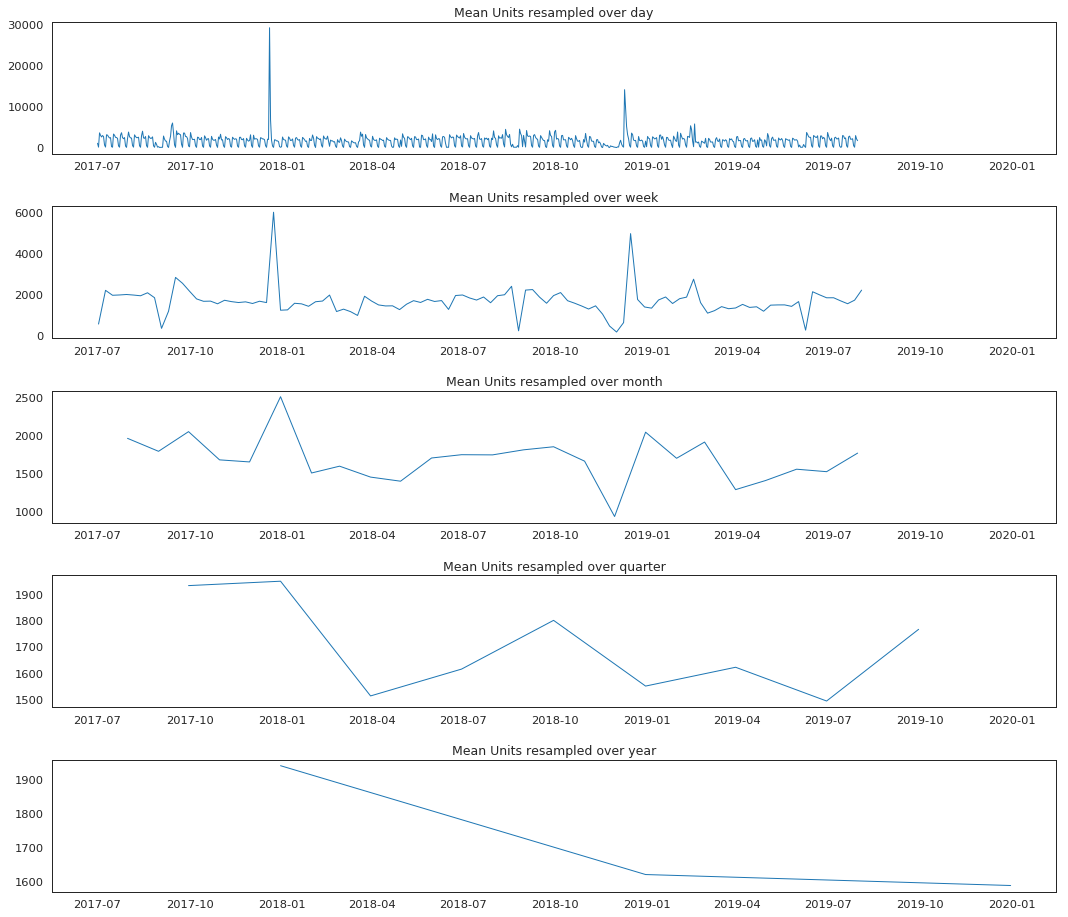

In [0]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Units'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Units resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Units'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Units resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Units'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Units resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Units'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Units resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Units'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Units resampled over year')
ax5.tick_params(axis='both', which='major');

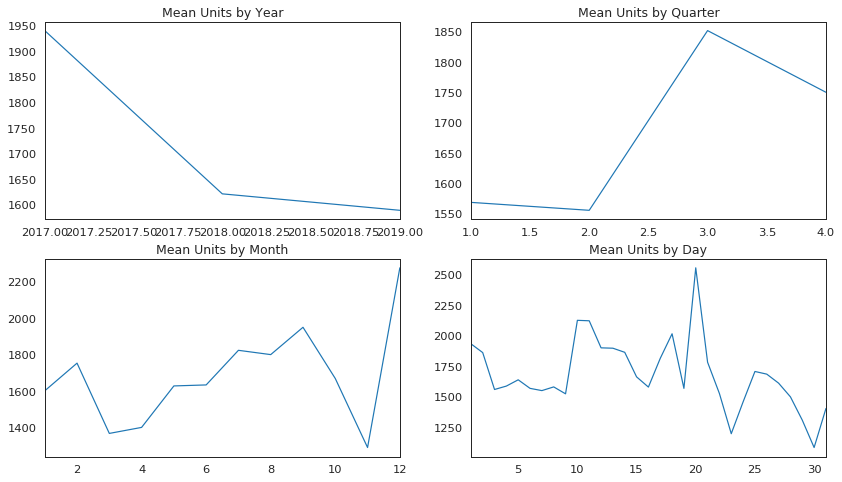

In [0]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('Year').Units.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Units by Year')

plt.subplot(2,2,2)
df.groupby('Quarter').Units.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Units by Quarter')

plt.subplot(2,2,3)
df.groupby('Month').Units.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Units by Month')

plt.subplot(2,2,4)
df.groupby('Day').Units.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Units by Day');

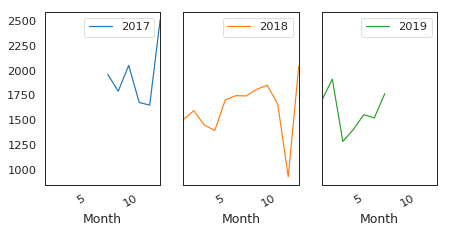

In [0]:
pd.pivot_table(df, values = 'Units',columns = "Year", index = "Month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

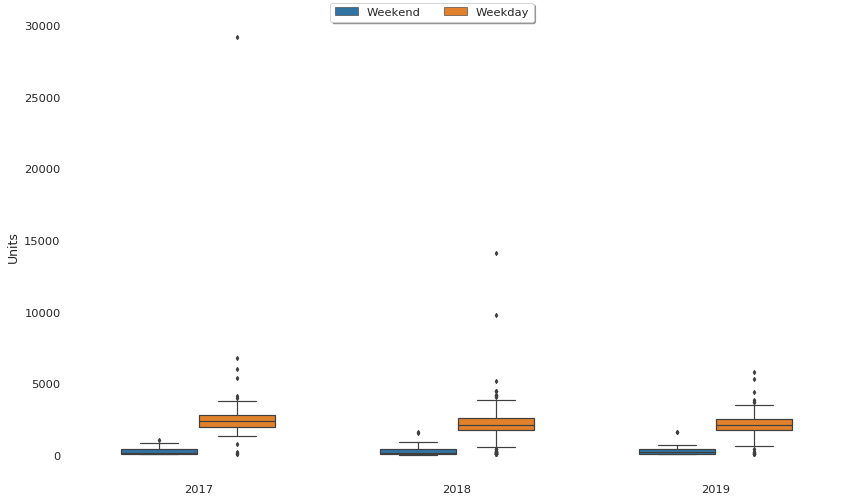

In [0]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(12,7)) 
plt1=sns.boxplot('Year','Units',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

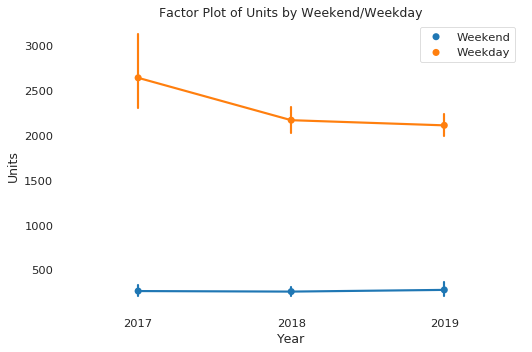

In [0]:
plt1=sns.factorplot('Year','Units',hue='Day',
                    data=df, size=5, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Units by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

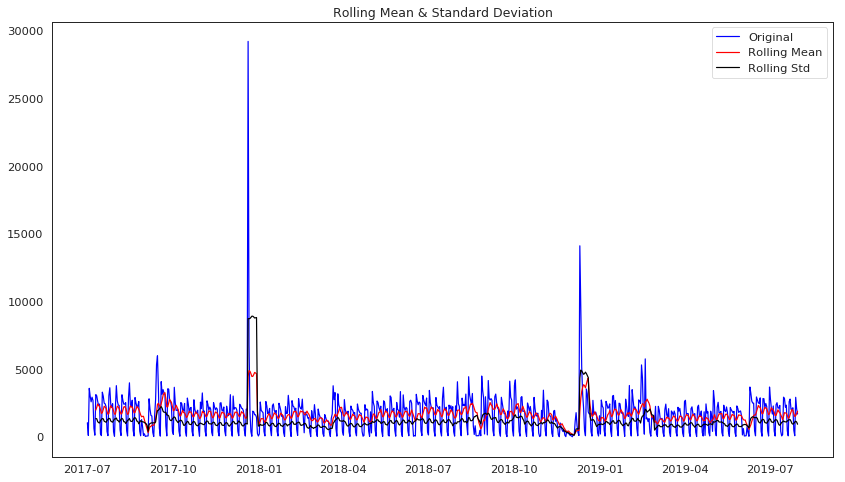

<Results of Dickey-Fuller Test>
Test Statistic                 -5.9135
p-value                         0.0000
#Lags Used                     20.0000
Number of Observations Used   740.0000
Critical Value (1%)            -3.4392
Critical Value (5%)            -2.8655
Critical Value (10%)           -2.5689
dtype: float64


In [0]:
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=10).mean()
    rolstd = timeseries.rolling(window=10).std()
    
    plt.figure(figsize=(14,8))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Units.dropna())

NameError: ignored

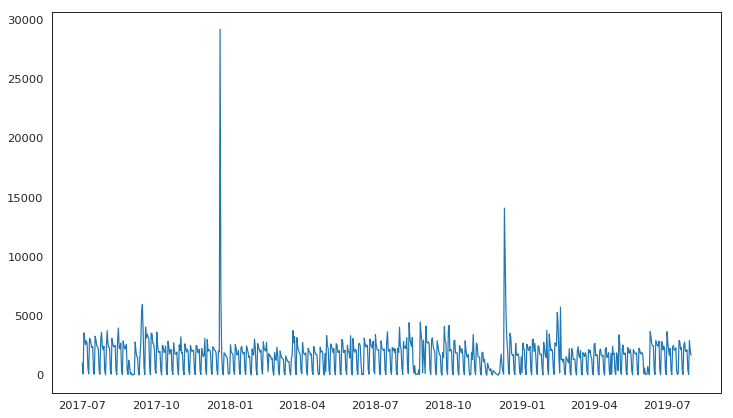

In [0]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

df['ma9'] = df.Units.rolling(window=9).mean()
rolling_mean2 = df.Units.rolling(window=50).mean()
plt.plot(df.Date, df.Units, label='AMD')
plt.plot(df.Date, rolling_mean, label='AMD 9 Day SMA', color='orange')
plt.plot(df.Date, rolling_mean2, label='AMD 50 Day SMA', color='magenta')
plt.legend(loc='upper left')
plt.show()



In [0]:
df['loess_5'] = pd.DataFrame(lowess(df.Units, np.arange(len(df.Units)), frac=0.03)[:, 1], index=df.index, columns=['Units'])

In [0]:
df.head(20)

,Date,Units,IsGunuKatsayi,Year,Quarter,Month,Day,weekday,ma9,loess_5
0,2017-07-01,1043,0.2500,2017,3,7,Weekend,0,nan,2039.7261
1,2017-07-02,107,0.0500,2017,3,7,Weekend,0,nan,2067.7892
2,2017-07-03,3584,1.0000,2017,3,7,Weekday,1,nan,2092.6031
3,2017-07-04,2994,1.0000,2017,3,7,Weekday,1,nan,2116.0550
4,2017-07-05,2587,1.0000,2017,3,7,Weekday,1,nan,2139.5777
5,2017-07-06,2929,1.0000,2017,3,7,Weekday,1,nan,2163.8709
6,2017-07-07,2681,1.0000,2017,3,7,Weekday,1,nan,2188.8977
7,2017-07-08,629,0.2500,2017,3,7,Weekend,0,nan,2213.3290
8,2017-07-09,123,0.0500,2017,3,7,Weekend,0,1853.0000,2233.9227
9,2017-07-10,3119,1.0000,2017,3,7,Weekday,1,2083.6667,2245.0244


In [0]:
dataset = df.ma9[8:761].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [0]:
from keras import optimizers
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.05))
model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.05))
model.add(LSTM(50,return_sequences = True))
model.add(Dropout(0.05))
model.add(LSTM(50))
model.add(Dropout(0.05))
model.add(Dense(1))
Adam=keras.optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer='Adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size= 32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience= 10)], verbose=1, shuffle=False)
model.summary()

Train on 571 samples, validate on 120 samples
Epoch 1/100
571/571 [==============================] - 4s 6ms/step - loss: 0.0671 - val_loss: 0.0079
Epoch 2/100
571/571 [==============================] - 0s 574us/step - loss: 0.0185 - val_loss: 0.0041
Epoch 3/100
571/571 [==============================] - 0s 587us/step - loss: 0.0167 - val_loss: 0.0037
Epoch 4/100
571/571 [==============================] - 0s 590us/step - loss: 0.0158 - val_loss: 0.0035
Epoch 5/100
571/571 [==============================] - 0s 581us/step - loss: 0.0141 - val_loss: 0.0033
Epoch 6/100
571/571 [==============================] - 0s 591us/step - loss: 0.0119 - val_loss: 0.0031
Epoch 7/100
571/571 [==============================] - 0s 575us/step - loss: 0.0101 - val_loss: 0.0031
Epoch 8/100
571/571 [==============================] - 0s 566us/step - loss: 0.0091 - val_loss: 0.0027
Epoch 9/100
571/571 [==============================] - 0s 565us/step - loss: 0.0079 - val_loss: 0.0026
Epoch 10/100
571/571 [=======

In [0]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))



Train Mean Absolute Error: 142.25100392009884
Train Root Mean Squared Error: 228.39647230014745
Test Mean Absolute Error: 92.98463400155994
Test Root Mean Squared Error: 121.0339865087601


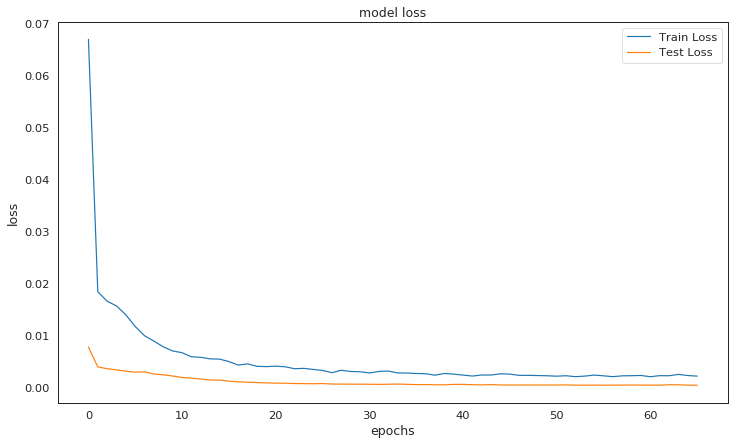

In [0]:
plt.figure(figsize=(12,7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

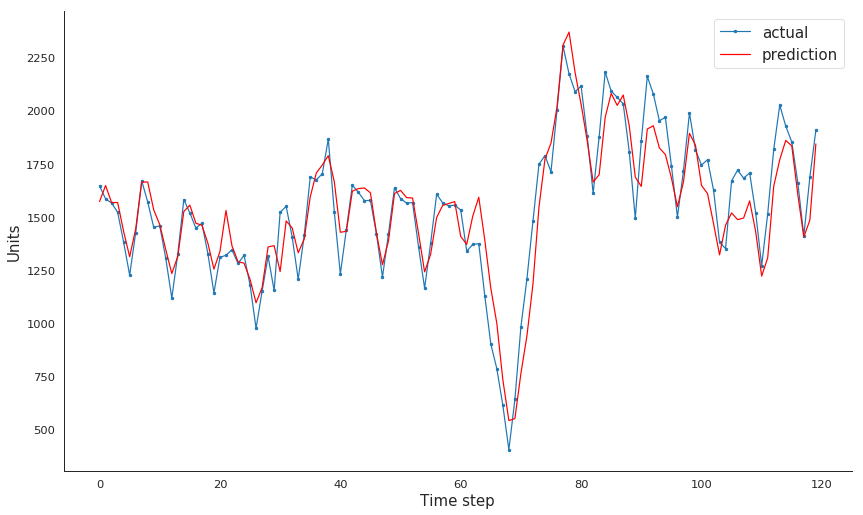

In [0]:
aa=[x for x in range(120)]
plt.figure(figsize=(12,7))
plt.plot(aa, Y_test[0][:120], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:120], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Units', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();